# Mnist Classification

Using the Deep Neural Network, I am going to figure out how to classify the mnist input data into the number.

### Dataset

The MNIST (Mixed National Institute of Standards and Technology) dataset is a dataset containing handwritten digit images, and is widely used to evaluate the performance of machine learning algorithms. The MNIST dataset consists of 70,000 samples of 28x28 pixel black and white images, each representing a digit from 0 to 9.

When you check the link: http://yann.lecun.com/exdb/mnist/
You can find that the datasets are no where, so the dataset is downloaded throught kaggle: https://www.kaggle.com/datasets/hojjatk/mnist-dataset

I tried different modules to import the data without decoding it, but as the links have an 404 error, I imported the datasets by my own. You don't need to understand the read_idx1_ubyte and read_idx3_ubyte for I simply got it from the internet.

In [ ]:
import numpy as np
import struct

np.random.seed(0)
def read_idx1_ubyte(file_name):
    with open(file_name, 'rb') as f:
        # Read the magic number (0x00000801)
        magic_number = struct.unpack('>I', f.read(4))[0]
        if magic_number != 2049:
            raise ValueError("Invalid IDX file format")
        
        # Read the number of labels
        num_labels = struct.unpack('>I', f.read(4))[0]
        
        # Read the label data
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        
    return labels
def read_idx3_ubyte(file_name):
    with open(file_name, 'rb') as f:
        # Read the magic number (0x00000801)
        magic_number = struct.unpack('>I', f.read(4))[0]
        if magic_number != 2051:
            raise ValueError("Invalid IDX file format")
        
        # Read the number of images
        num_images = struct.unpack('>I', f.read(4))[0]
        
        # Read the number of rows and columns (28x28 for MNIST)
        num_rows = struct.unpack('>I', f.read(4))[0]
        num_columns = struct.unpack('>I', f.read(4))[0]
        
        # Read the image data
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape(num_images, num_rows, num_columns)
        
    return images

root = "files/DNN/archive/"
X_train = read_idx3_ubyte(root+'train-images.idx3-ubyte')
y_train = read_idx1_ubyte(root+'train-labels.idx1-ubyte')

X_test = read_idx3_ubyte(root+'t10k-images.idx3-ubyte')
y_test = read_idx1_ubyte(root+'t10k-labels.idx1-ubyte')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Dimension reduction to make the input data 1-dimensional
X_train = X_train.reshape(60000, -1)
X_test = X_test.reshape(10000, -1)
y_train_one_hot = np.eye(10)[y_train]  # one-hot encoding
y_test_one_hot = np.eye(10)[y_test]  # one-hot encoding
print(X_train.shape, y_train_one_hot.shape)
print(X_test.shape, y_test_one_hot.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


### Basic DNN Implementation

First, I loaded the DNN defined in step 4 above. Instead, in order to use various activation functions and optimizers, we redefine the DNN class as an abstract class and the corresponding methods as abstract methods. Later, I will define inheritant classes and insert the necessary functions.

In [ ]:
from tqdm import tqdm
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import time

class DNN(ABC):
    def __init__(self, input_size, hidden_layers, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []
        
        prev_layer_size = self.input_size
        for hidden_layer_size in (self.hidden_layers + [output_size]):
            weight = np.random.randn(prev_layer_size, hidden_layer_size) * 0.01
            bias = np.zeros((1, hidden_layer_size))
            self.weights.append(weight)
            self.biases.append(bias)
            prev_layer_size = hidden_layer_size
            
    def forward_propagation(self, X):
        self.a = [X]
        self.z = []
        for i in range(len(self.weights)):
            z = np.dot(self.a[i], self.weights[i]) + self.biases[i]
            self.z.append(z)
            a = self.activation(z)
            self.a.append(a)
        return self.a[-1]
    
    def backward_propagation(self, X, y):
        self.batch_size = X.shape[0]
        y_pred = self.forward_propagation(X)
        loss_derivative = self.loss_derivative(y_pred, y)
        
        dA = loss_derivative * self.activation_derivative(self.a[-1])
        dZ = dA
        
        dW = []
        db = []
        
        dW.append(np.dot(self.a[-2].T, dZ))
        db.append(np.sum(dZ, axis=0, keepdims=True))
        
        dA = np.dot(dZ, self.weights[-1].T)
        
        for i in range(len(self.weights) - 2, -1, -1):
            dZ = dA * self.activation_derivative(self.a[i + 1])
            dW.append(np.dot(self.a[i].T, dZ))
            db.append(np.sum(dZ, axis=0, keepdims=True))
            dA = np.dot(dZ, self.weights[i].T)
        
        return dW[::-1], db[::-1]
    
    @abstractmethod
    def activation(self, x):
        pass
    
    @abstractmethod
    def activation_derivative(self, x):
        pass

    @abstractmethod
    def optimizer(self, dW, db):
        pass
    
    def softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True)) # overflow prevention
        return e_x / np.sum(e_x, axis=-1, keepdims=True)
    
    def compute_loss(self, y_pred, y_true):
        # Cross Entropy Loss
        return -np.mean(y_true * np.log(y_pred + 1e-8))
    
    def loss_derivative(self, y_pred, y_true):
        return y_pred - y_true
    
    def mini_batch_train(self, X_train, y_train, X_test, y_test, batch_size=32, epochs=1000, loss_rate = 1):
        m = X_train.shape[0]
        self.train_losses = []
        self.test_losses = []
        self.train_time = []
        start_time = time.time()
        for epoch in tqdm(range(epochs)):
            indices = np.random.permutation(m)
            X_shuffled_train = X_train[indices]
            y_shuffled_train = y_train[indices]
            
            for i in range(0, m, batch_size):
                X_batch_train = X_shuffled_train[i:i+batch_size]
                y_batch_train = y_shuffled_train[i:i+batch_size]
                
                dW, db = self.backward_propagation(X_batch_train, y_batch_train)
                    
                self.optimizer(dW, db)  
                
            if epoch % loss_rate == 0:
                # training loss calculation
                y_pred = self.forward_propagation(X_train)
                loss = self.compute_loss(y_pred, y_train)
                self.train_losses.append(loss)
                # test loss calculation
                y_pred_test = self.forward_propagation(X_test)
                loss = self.compute_loss(y_pred_test, y_test)
                self.test_losses.append(loss)
            self.train_time.append(time.time() - start_time)
                
        self.plot_losses(self.train_losses, self.test_losses, epochs, loss_rate)
        
    def predict(self, X):
        y_pred = self.forward_propagation(X)
        return y_pred
        
    def plot_losses(self, train_losses, test_losses, epochs, loss_rate):
        plt.plot(range(1, epochs+1, loss_rate), train_losses, label="Train Loss")
        plt.plot(range(1, epochs+1, loss_rate), test_losses, label="Test Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training and Test Loss over Epochs")
        plt.legend()
        plt.show()

### 1. Sigmoid + Stochastic Gradient Descent

In [2]:
class DNN1(DNN):
    def softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True)) # overflow prevention
        return e_x / np.sum(e_x, axis=-1, keepdims=True)
    
    def sigmoid(self, x):
        x = np.clip(x, -500, 500)  # overflow prevention
        return 1 / (1 + np.exp(-x))
    
    def activation(self, x):
        if len(self.weights) == len(self.a):
            return self.softmax(x)
        else:
            return self.sigmoid(x)
    
    def activation_derivative(self, x):
        # Implement the derivative of the activation function (e.g., sigmoid)
        return x * (1 - x)
    
    def optimizer(self, dW, db):
        # Implement gradient update (gradient descent)
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dW[i]
            self.biases[i] -= self.learning_rate * db[i]

model1 = DNN1(784, [64, 32], 10, 0.01)
model1.mini_batch_train(X_train, y_train_one_hot, X_test, y_test_one_hot, epochs=200)

NameError: name 'np' is not defined

### User interaction

Using the pygame module, by drawing on the canvas and closing it, the model can receive the numeric data from it and can predict its result from our model.

In [ ]:
# import pygame
# import matplotlib.pyplot as plt

# pygame.init()

# width, height = 280, 280  # 10 times upscaled canvas of 28 x 28
# screen = pygame.display.set_mode((width, height))
# pygame.display.set_caption('Draw and Save Image')

# BLACK = (0, 0, 0)
# WHITE = (255, 255, 255)

# drawing = False
# last_pos = None

# img = np.zeros((28, 28), dtype=int)

# running = True
# screen.fill(WHITE)
# while running:
#     for event in pygame.event.get():
#         if event.type == pygame.QUIT:
#             running = False
#         elif event.type == pygame.MOUSEBUTTONDOWN:
#             drawing = True
#             last_pos = event.pos
#         elif event.type == pygame.MOUSEBUTTONUP:
#             drawing = False
#             last_pos = None
#         elif event.type == pygame.MOUSEMOTION and drawing:
#             current_pos = event.pos
#             pygame.draw.line(screen, BLACK, last_pos, current_pos, 5)
#             last_pos = current_pos

#     pygame.display.update()

#     for i in range(0, 280, 10):
#         for j in range(0, 280, 10):
#             brightness = 0
#             for k in range(10):
#                 for l in range(10):
#                     pixel_color = screen.get_at((j+l, i+k))
#                     brightness += (pixel_color[0] + pixel_color[1] + pixel_color[2]) // 3
#             img[i//10, j//10] = 255 - brightness // 100
# pixels = pygame.surfarray.array3d(screen)
# pygame.quit()

# # Image plot
# pixels = np.transpose(pixels, (1, 0, 2))
# plt.imshow(pixels)
# plt.axis('off')
# plt.show()

# # Image to data
# img = np.array(img)
# img_min = np.min(img)
# img_max = np.max(img)
# img_normalized = ((img - img_min) / (img_max - img_min)) * 255
# X = img.reshape(1, -1)

# # Image prediction
# print("the predicted number is:", int(np.argmax(model1.predict(X))))

### 2. Sigmoid + Adam

100%|██████████| 200/200 [07:38<00:00,  2.29s/it]


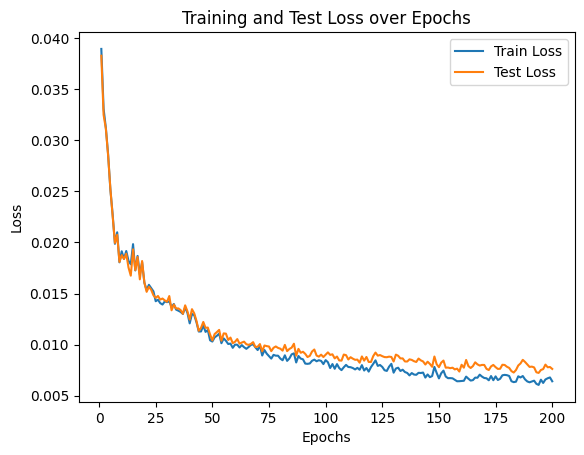

In [ ]:
class DNN2(DNN):
    def softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True)) # overflow prevention
        return e_x / np.sum(e_x, axis=-1, keepdims=True)
    
    def sigmoid(self, x):
        x = np.clip(x, -500, 500)  # overflow prevention
        return 1 / (1 + np.exp(-x))
    
    def activation(self, x):
        if len(self.weights) == len(self.a):
            return self.softmax(x)
        else:
            return self.sigmoid(x)
    
    def activation_derivative(self, x):
        # Implement the derivative of the activation function (e.g., sigmoid)
        return x * (1 - x)
    
    def optimizer(self, dW, db):
        # Adam hyperparameters
        beta_1 = self.learning_rate*100
        beta_2 = 1 - self.learning_rate
        epsilon = 1e-8

        # Initialize moment estimates if not already initialized
        if not hasattr(self, 'm') or not hasattr(self, 'v'):
            self.m = [np.zeros_like(w) for w in self.weights]  # 1st moment (mean)
            self.v = [np.zeros_like(w) for w in self.weights]  # 2nd moment (variance)
            self.t = 0  # timestep

        # Update timestep
        self.t += 1

        # Adam parameter update
        for i in range(len(self.weights)):
            # Update first moment estimate (m)
            self.m[i] = beta_1 * self.m[i] + (1 - beta_1) * dW[i]
            self.v[i] = beta_2 * self.v[i] + (1 - beta_2) * (dW[i] ** 2)

            # Bias correction
            m_hat = self.m[i] / (1 - beta_1 ** self.t)
            v_hat = self.v[i] / (1 - beta_2 ** self.t)

            # Update weights and biases
            self.weights[i] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
            self.biases[i] -= self.learning_rate * db[i]  # Biases do not use Adam updates
    
model2 = DNN2(784, [64, 32], 10, 0.001)
model2.mini_batch_train(X_train, y_train_one_hot, X_test, y_test_one_hot, epochs=200)

### 3. ReLU + SGD

In [ ]:
class DNN3(DNN):
    def reLU(self, x):
        return np.maximum(0, x)
    
    def activation(self, x):
        if len(self.weights) == len(self.a):
            return self.softmax(x)
        else:
            return self.reLU(x)
    
    def activation_derivative(self, x):
        return np.where(x > 0, 1, 0)
    
    def optimizer(self, dW, db):
        # Implement gradient update (gradient descent)
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dW[i]
            self.biases[i] -= self.learning_rate * db[i]
            
model3 = DNN3(784, [64, 32], 10, 0.01)
model3.mini_batch_train(X_train, y_train_one_hot, X_test, y_test_one_hot, epochs=200)

 28%|██▊       | 57/200 [01:26<04:31,  1.90s/it]

I believe this is the great example of the dying ReLU problem. I believed that LeakyLU or ELU could solve this problem, so I tried to implement another model with leakyLU to solve it.

  8%|▊         | 17/200 [00:25<04:39,  1.53s/it]/var/folders/4q/4ynpz1m96jqf3tsct66_ff540000gn/T/ipykernel_68627/75767569.py:70: RuntimeWarning: invalid value encountered in subtract
  e_x = np.exp(x - np.max(x, axis=-1, keepdims=True)) # overflow prevention
100%|██████████| 200/200 [05:29<00:00,  1.65s/it]


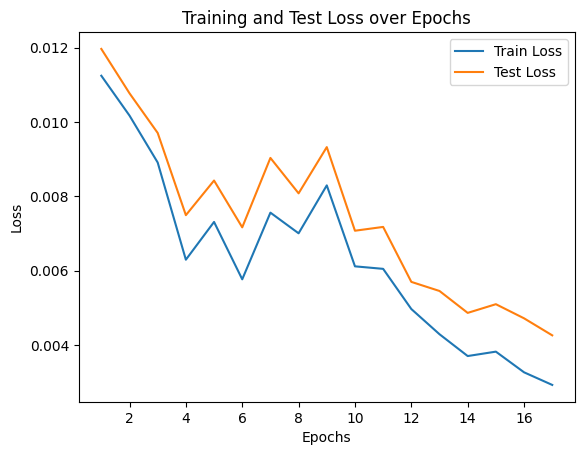

In [ ]:
class DNN3_1(DNN):
    def LeakyReLU(self, x):
        return np.maximum(0.01*x, x)
    
    def activation(self, x):
        if len(self.weights) == len(self.a):
            return self.softmax(x)
        else:
            return self.LeakyReLU(x)
    
    def activation_derivative(self, x):
        return np.where(x > 0, 1, 0.01)
    
    def optimizer(self, dW, db):
        # Implement gradient update (gradient descent)
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dW[i]
            self.biases[i] -= self.learning_rate * db[i]
            
model3_1 = DNN3_1(784, [64, 32], 10, 0.01)
model3_1.mini_batch_train(X_train, y_train_one_hot, X_test, y_test_one_hot, epochs=200)

As you can see, the LeakyLU solved the dying ReLU problem.

### 4. ReLU + Adam

100%|██████████| 200/200 [08:49<00:00,  2.65s/it]


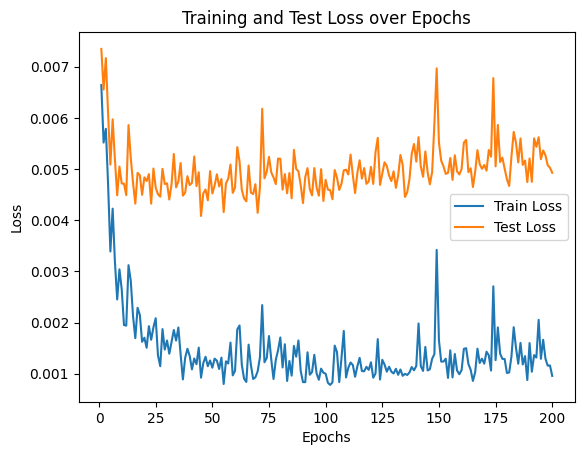

In [ ]:
class DNN4(DNN):
    def reLU(self, x):
        return np.maximum(0, x)
    
    def activation(self, x):
        if len(self.weights) == len(self.a):
            return self.softmax(x)
        else:
            return self.reLU(x)
    
    def activation_derivative(self, x):
        return np.where(x > 0, 1, 0)
    
    def optimizer(self, dW, db):
        # Adam hyperparameters
        beta_1 = self.learning_rate*100
        beta_2 = 1 - self.learning_rate
        epsilon = 1e-8

        # Initialize moment estimates if not already initialized
        if not hasattr(self, 'm') or not hasattr(self, 'v'):
            self.m = [np.zeros_like(w) for w in self.weights]  # 1st moment (mean)
            self.v = [np.zeros_like(w) for w in self.weights]  # 2nd moment (variance)
            self.t = 0  # timestep

        # Update timestep
        self.t += 1

        # Adam parameter update
        for i in range(len(self.weights)):
            # Update first moment estimate (m)
            self.m[i] = beta_1 * self.m[i] + (1 - beta_1) * dW[i]
            self.v[i] = beta_2 * self.v[i] + (1 - beta_2) * (dW[i] ** 2)

            # Bias correction
            m_hat = self.m[i] / (1 - beta_1 ** self.t)
            v_hat = self.v[i] / (1 - beta_2 ** self.t)

            # Update weights and biases
            self.weights[i] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
            self.biases[i] -= self.learning_rate * db[i]  # Biases do not use Adam updates
            
model4 = DNN4(784, [64, 32], 10, 0.001)
model4.mini_batch_train(X_train, y_train_one_hot, X_test, y_test_one_hot, epochs=200)

But the interesting thing comes in here, where ReLU didn't showed up with the bad performance. Instead of using SGD, if we use Adam with ReLU, the performance was the best among them.

**Question: Why ReLU kills neuron depending on the optimizer?**

It is because adam is adaptive learning but SGD is not. If SGD's constant learning rate is too big or the first weights are set to be wrong, the SGD + ReLU model is likely to kill the neuron. However, adam adaptively adjusts the learning rate over time (epoch), it gives the less possibility to kill the neurons.

### 5. Results

We will compare the elapsed time, loss reduction over time, through graph.

1. Time Comparison graph

In [ ]:
print(f"elapsed time for Sigmoid + SGD model: {model1.train_time[-1]:.2f} seconds.")
print(f"elapsed time for Sigmoid + Adam model: {model2.train_time[-1]:.2f} seconds.")
print(f"elapsed time for ReLU + SGD model: {model3.train_time[-1]:.2f} seconds.")
print(f"elapsed time for ReLU + Adam model: {model4.train_time[-1]:.2f} seconds.")

elapsed time for Sigmoid + SGD model: 415.14 seconds.
elapsed time for Sigmoid + Adam model: 570.83 seconds.
elapsed time for ReLU + SGD model: 282.77 seconds.
elapsed time for ReLU + Adam model: 529.46 seconds.


2. Train loss comparison graph

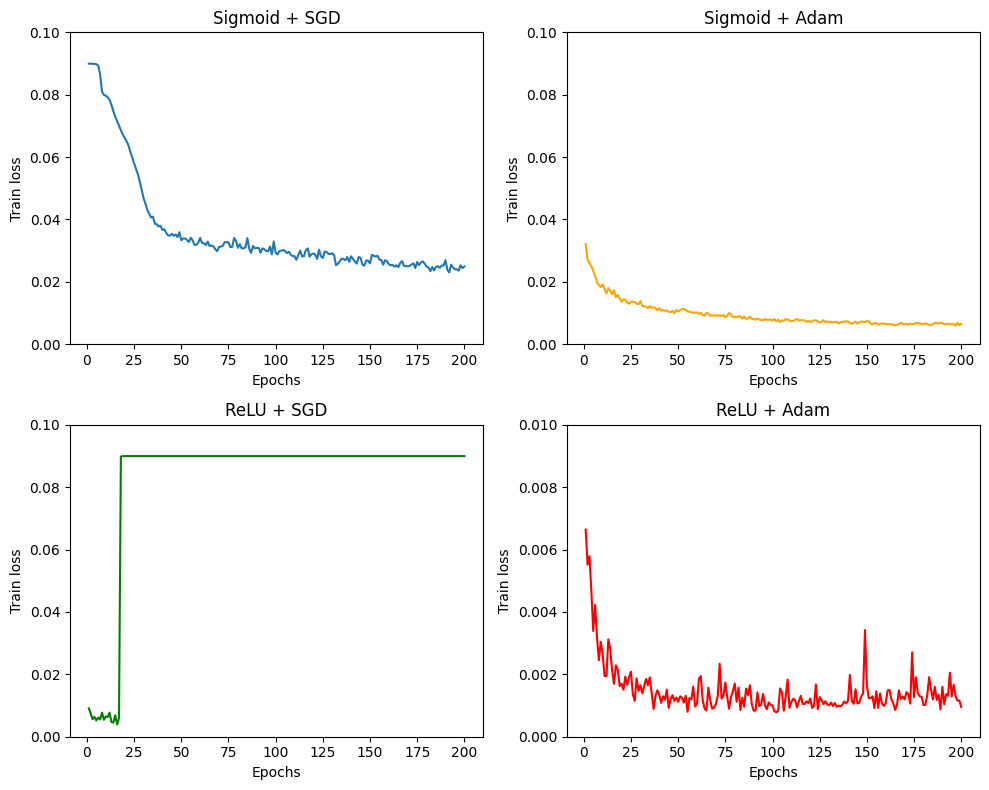

In [ ]:
epochs = np.arange(1, 201)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# 1st graph: Sigmoid + SGD
axes[0, 0].plot(epochs, model1.train_losses, label="Adam + ReLU")
axes[0, 0].set_title("Sigmoid + SGD")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Train loss")
axes[0, 0].set_ylim(0, 0.1)

# 2nd graph: Sigmoid + Adam
axes[0, 1].plot(epochs, model2.train_losses, label="Adam + Sigmoid", color="orange")
axes[0, 1].set_title("Sigmoid + Adam")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Train loss")
axes[0, 1].set_ylim(0, 0.1)

# 3rd graph: ReLU + SGD
axes[1, 0].plot(epochs, model3.train_losses, label="SGD + ReLU", color="green")
axes[1, 0].set_title("ReLU + SGD")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("Train loss")
axes[1, 0].set_ylim(0, 0.1)

# 4th graph: ReLU + Adam
axes[1, 1].plot(epochs, model4.train_losses, label="SGD + Sigmoid", color="red")
axes[1, 1].set_title("ReLU + Adam")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Train loss")
axes[1, 1].set_ylim(0, 0.01)

plt.tight_layout()
plt.show()

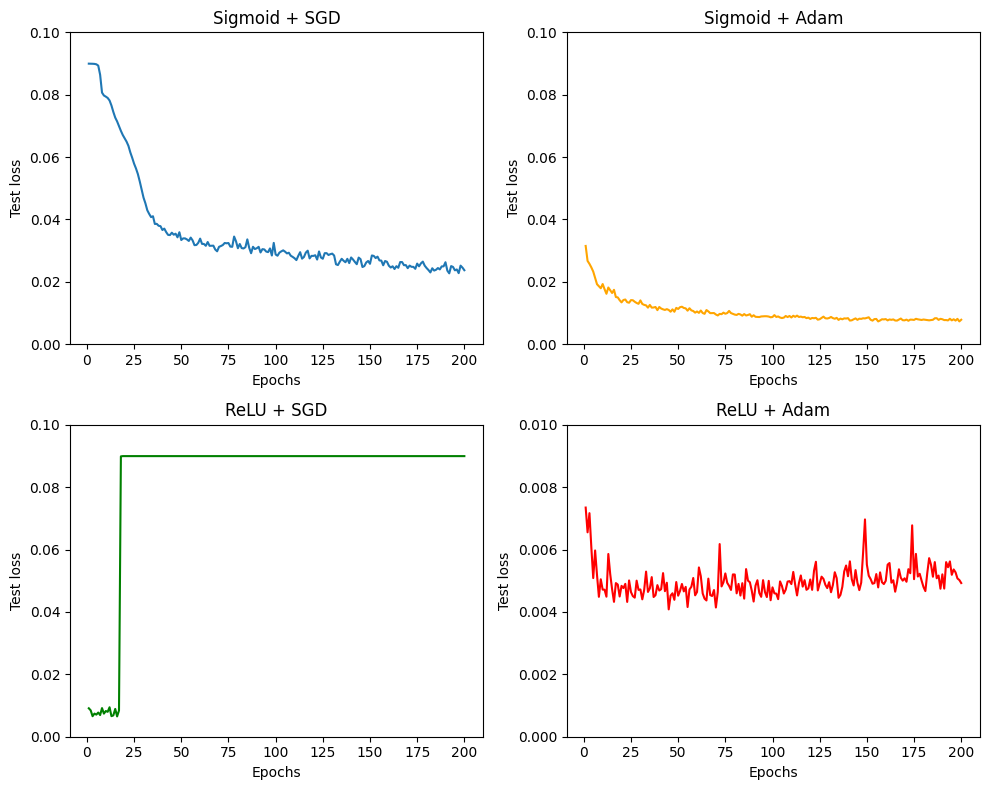

In [ ]:
epochs = np.arange(1, 201)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# 1st graph: Sigmoid + SGD
axes[0, 0].plot(epochs, model1.test_losses, label="Adam + ReLU")
axes[0, 0].set_title("Sigmoid + SGD")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Test loss")
axes[0, 0].set_ylim(0, 0.1)

# 2nd graph: Sigmoid + Adam
axes[0, 1].plot(epochs, model2.test_losses, label="Adam + Sigmoid", color="orange")
axes[0, 1].set_title("Sigmoid + Adam")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Test loss")
axes[0, 1].set_ylim(0, 0.1)

# 3rd graph: ReLU + SGD
axes[1, 0].plot(epochs, model3.test_losses, label="SGD + ReLU", color="green")
axes[1, 0].set_title("ReLU + SGD")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("Test loss")
axes[1, 0].set_ylim(0, 0.1)

# 4th graph: ReLU + Adam
axes[1, 1].plot(epochs, model4.test_losses, label="SGD + Sigmoid", color="red")
axes[1, 1].set_title("ReLU + Adam")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Test loss")
axes[1, 1].set_ylim(0, 0.01)

plt.tight_layout()
plt.show()

### 6. Obesrvation

**First observation**

The bump in the Sigmoid + SGD model
- Wrong (maybe) learning rate. The loss might increase in two different reasons: 1. the update rate is overwhelming to the model, 2. it might jump above the local minima. It will give the jump on the losses.

**Second observation**

Evenly converging loss in the Sigmoid + Adam model
- Gradient vanishing problem. Sigmoid function is limited into 0 to 1 output. So big input value can let the slope to be very small, which gives less updates in the parameters. 200 epochs works pretty well in this problem, but if we fit more epochs using this model, the model might not learn before the best fitting model has trained.

- In 1_activation_function.ipynb file, we discussed this problem and sigmoid activation might perform better with tanh activation because it is limited to -1 to 1 output so the average slope is 0. So I trained another model using tanh function and compared the performance between the two.

100%|██████████| 200/200 [07:18<00:00,  2.19s/it]


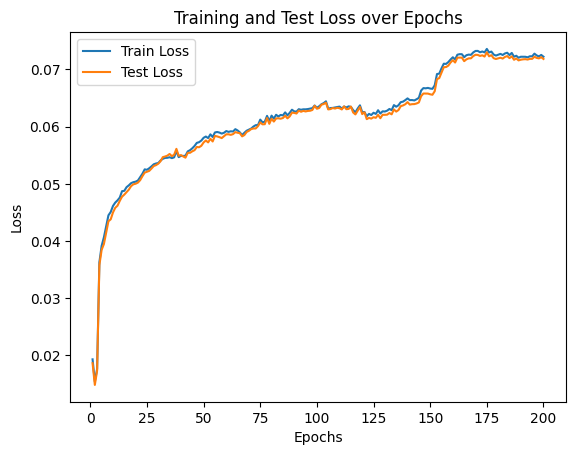

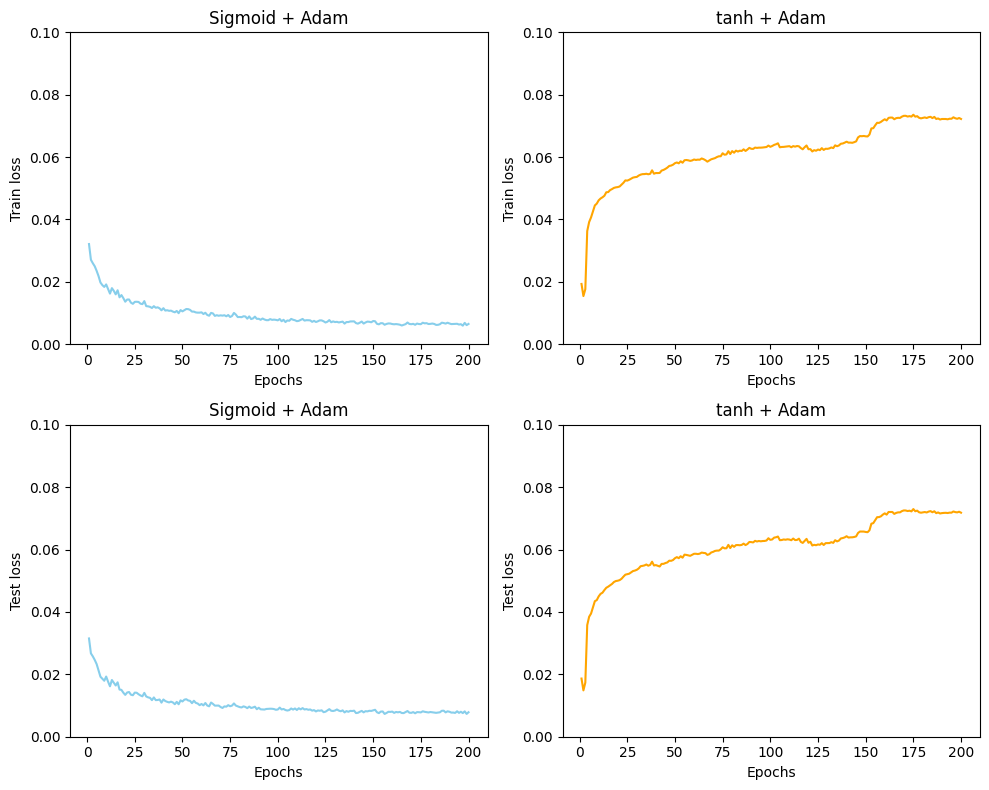

In [ ]:
class DNN2_1(DNN):
    def softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True)) # overflow prevention
        return e_x / np.sum(e_x, axis=-1, keepdims=True)
    
    def tanh(self, x):
        x = np.clip(x, -500, 500)  # overflow prevention
        return np.tanh(x)
    
    def activation(self, x):
        if len(self.weights) == len(self.a):
            return self.softmax(x)
        else:
            return self.tanh(x)
    
    def activation_derivative(self, x):
        return 1 - np.tanh(x)**2
    
    def optimizer(self, dW, db):
        # Adam hyperparameters
        beta_1 = self.learning_rate*100
        beta_2 = 1 - self.learning_rate
        epsilon = 1e-8

        # Initialize moment estimates if not already initialized
        if not hasattr(self, 'm') or not hasattr(self, 'v'):
            self.m = [np.zeros_like(w) for w in self.weights]  # 1st moment (mean)
            self.v = [np.zeros_like(w) for w in self.weights]  # 2nd moment (variance)
            self.t = 0  # timestep

        # Update timestep
        self.t += 1

        # Adam parameter update
        for i in range(len(self.weights)):
            # Update first moment estimate (m)
            self.m[i] = beta_1 * self.m[i] + (1 - beta_1) * dW[i]
            self.v[i] = beta_2 * self.v[i] + (1 - beta_2) * (dW[i] ** 2)

            # Bias correction
            m_hat = self.m[i] / (1 - beta_1 ** self.t)
            v_hat = self.v[i] / (1 - beta_2 ** self.t)

            # Update weights and biases
            self.weights[i] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
            self.biases[i] -= self.learning_rate * db[i]  # Biases do not use Adam updates
    
model2_1 = DNN2_1(784, [64, 32], 10, 0.001)
model2_1.mini_batch_train(X_train, y_train_one_hot, X_test, y_test_one_hot, epochs=200)

epochs = np.arange(1, 201)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# 1st graph: Sigmoid + SGD
axes[0, 0].plot(epochs, model2.train_losses, label="Sigmoid + Adam", color = "skyblue")
axes[0, 0].set_title("Sigmoid + Adam")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Train loss")
axes[0, 0].set_ylim(0, 0.1)

# 2nd graph: Sigmoid + Adam
axes[0, 1].plot(epochs, model2_1.train_losses, label="tanh + Adam", color= "orange")
axes[0, 1].set_title("tanh + Adam")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Train loss")
axes[0, 1].set_ylim(0, 0.1)

# 1st graph: Sigmoid + SGD
axes[1, 0].plot(epochs, model2.test_losses, label="Sigmoid + Adam", color = "skyblue")
axes[1, 0].set_title("Sigmoid + Adam")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("Test loss")
axes[1, 0].set_ylim(0, 0.1)

# 2nd graph: Sigmoid + Adam
axes[1, 1].plot(epochs, model2_1.test_losses, label="tanh + Adam", color= "orange")
axes[1, 1].set_title("tanh + Adam")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Test loss")
axes[1, 1].set_ylim(0, 0.1)

plt.tight_layout()
plt.show()

**Third observation**
Weird line in the ReLU + SGD model
- Dyting ReLU problem. discussed above.

**Forth obesrvation**
Oscilliating line in the ReLU + Adam model
- This model is already showing its best performance at around 25 epochs. It means the learning rate is the fastest, yet any other problems shown in the First~Third observations are not likely to be shown. I think this is the reason why people are willig to use the combination of the ReLU and Adam model.